# Bab 5 Waffle dan Multivariate Regression

Pada bab sebelumnya sudah dijelaskan bangaimana membangun regresi menggunakan bayesian. Kasus pada bab sebelumnya adalah menggunakan berat badan sebagai variabel terobservasi dan menentukan tinggi dari berat badan. Sekarang akan dijelaskan kausalitas (apakah suatu variabel kontrol berhubungan dengan variabel terikat. 

Tentuunya pada kasus tinggi badan, relasi dapat dlilihat dengan mudah dan cukup intuitif. Tentunya hal ini tidak berlaku untuk penelitan-penelitian lainya seperti hubungan antara biaya promosi dan jumlah sales atau efek obat yang baru dibuat terhadap suatu penyakit. 

Dikarenakan dalam suatu penelitian seringkali didapati variabel observasi bermacam-macam, maka regresi menggunakan lebih dari satu jenis variabel akan sering dijumpai.

Pada bukunya, Pak Richard menejelaskan kenapa regresi multivariate ini penting.
1. adanya *confound* dalam statistik. *confound* ini dapat dijelaskan sebagai susatu sebab musabab yang menyesatkan. Seperti banyaknya rumah penyaji waffle sebagai penyebab perceraian di Amerika Setikat. Ini dapat menyembunyikan variabel yang benar-benar berpengaruh dan memunculkan variabel yang sebenarnya tidak memiliki pengaruh apapun tapi berdasarkan data terlihat berpengaruh.

2. Banyaknya fenomena yang disebabkan oleh berbagai kasus. Ini sangat mungkin terjadi dalam penelitian soosial. Mungkin saat variabel-variabel ini dipisahkan dan dibuat model sendiri tidak memiliki pengharuh, akan tetapi saat digabungkan, efeknya akan teramplifikasi. Begitu juga sebaliknya, mungkin ada variabel yang apabila sendiri sangant berpengatuh tetapi saat digabugnkan dengan variabel lainya akan saling mengatenuasi.

3. Interaksi antar varaibel juga berpengaruh seperti yang dijelaskan pada poin kedua.

Pada bab ini akan dijelaskan tentang *confound* dalam data.

### Asosiasi Palsu



In [1]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline

class LinearModelling:
    def __init__(self, dataframe):
        self.df = dataframe
        self.feature = []
        self.trace_df = None
        self.model = None
        
        self.fig = None
        self.ax = None
        
        self.valid_distribution = ['normal', 'uniform']
        
        self.config_validation_map = {
            "intercept": self.__validate_config_intercept,
            "gradient": self.__validate_config_gradient,
            "prior": self.__validate_config_prior,
            "equation": self.__validate_config_equation,
            "result": self.__validate_config_result
        }
        
        self.validate_distribution_map = {
            "normal": self.__validate_distribution_normal,
            "uniform": self.__validate_distribution_uniform
        }

        self.model_distribution_map = {
            "normal": self.__construct_distribution_normal,
            "uniform": self.__construct_distribution_uniform,
        }
        
        self.generate_distribution_map = {
            "normal": self.__generate_random_variable_normal
        }
        
        self.equation_support = ['linear']
        
    # Public
    def add_feature(self, column: str) -> 'void':
        self.feature.append(self.df[column])
        return
    
    def add_model(self, model: 'pymc3_model'):
        self.model = model
        
    def set_model_config(self, config):
        self.__validate_config(config)
        self.config = config
    
    def get_current_config(self):
        return self.config
    
    def construct_linear_model(self):
        self.model_buffer = {}
        with pm.Model() as model:
            for variable in self.config.keys():
                self.model_buffer[variable] = self.__convert_config_to_model(variable)
            
        self.model = model
    
    def get_sample(self, number_sample, tune=1000):
        if self.model is None:
            raise Exception("Model Not constructed yet; use construct_model method first")
        
        with self.model:
            trace_model = pm.sample(number_sample, tune=tune)
            self.trace_model = trace_model
            self.trace_df = pm.trace_to_dataframe(trace_model)

    def get_trace_dataframe(self):
        if self.trace_df is None:
            raise Exception("Trace is not available; use get_sample method first")
        return self.trace_df
         
    def plot_trace_information(self):
        with self.model:
            az.plot_trace(self.trace_model)
            
    def plot_full(self):
        self.__init_plot()
        gradient_variables = self.__find_gradient_variables()
        result_variables = self.__find_result_variables()
        if len(gradient_variables) > 1 or len(result_variables) > 1:
            raise Exception("Gradient Variable or Result variable is more than one; use specific_plot instead")
        self.__plot_scatter(gradient_variables[0], result_variables[0])
        self.__plot_mean_regression(gradient_variables[0])
        self.__plot_mean_hdi(gradient_variables[0])
        self.__plot_mean_actual_hdi(gradient_variables[0])
    
    # Private
    def __init_plot(self):
        fig, ax = plt.subplots()
        fig.set_figwidth(16)
        fig.set_figheight(12)
        
        self.fig = fig
        self.ax = ax
        
    def __plot_scatter(self, gradient_variable, result_variable):
        x_axis_var = self.config[gradient_variable]['feature']
        y_axis_var = self.config[result_variable]['observed']
        x_data = self.df[x_axis_var]
        y_data = self.df[y_axis_var]
        self.ax.scatter(x_data, y_data, alpha=.1)
        return
        
    def __plot_mean_regression(self, gradient_variable):
        feature = self.config[gradient_variable]['feature']
        x_axis = np.sort(self.df[feature])
        intercept_variable = self.__find_intercept_variables()[0]
        y_axis = self.trace_df[intercept_variable].mean() + self.trace_df[gradient_variable].mean() * x_axis
        self.ax.plot(x_axis, y_axis)
        
    
    def __plot_mean_hdi(self, gradient_variable):
        low_limit, high_limit = self.__get_hdi_mean_boundaries(gradient_variable)
        x_axis = np.sort(self.df[self.config[gradient_variable]['feature']])
        self.ax.fill_between(x_axis, low_limit, high_limit, alpha=.2, color='black')
    
    def __plot_mean_actual_hdi(self, gradient_variable):
        low_limit, high_limit = self.__get_hdi_actual_boundaries(gradient_variable)
        x_axis = np.sort(self.df[self.config[gradient_variable]['feature']])
        self.ax.fill_between(x_axis, low_limit, high_limit, alpha=.2, color='black')
        
    def __get_hdi_mean_boundaries(self, gradient_variable):
        intercept_variable = self.__find_intercept_variables()[0]
        feature = self.config[gradient_variable]['feature']
        lower_bound, upper_bound = [], []
        for i in np.sort(self.df[feature]):
            result = self.trace_df[intercept_variable] + self.trace_df[gradient_variable] * i
            [low_limit, high_limit] = az.hdi(np.array(result), hdi = .89)
            lower_bound.append(low_limit)
            upper_bound.append(high_limit)
        return lower_bound, upper_bound
    
    def __get_hdi_actual_boundaries(self, gradient_variable):
        intercept_variable = self.__find_intercept_variables()[0]
        feature = self.config[gradient_variable]['feature']
        lower_bound, upper_bound = [], []
        result_config = self.config[self.__find_result_variables()[0]]
        result_distribution_type = result_config['distribution']
        for i in np.sort(self.df[feature]):
            result = self.trace_df[intercept_variable] + self.trace_df[gradient_variable] * i
            dist_prop = {'loc': result, 'scale': self.trace_df[result_config['sd']]}
            likelihood = self.generate_distribution_map[result_distribution_type](**dist_prop)
            [low_limit, high_limit] = az.hdi(np.array(likelihood), hdi = .89)
            lower_bound.append(low_limit)
            upper_bound.append(high_limit)
        return lower_bound, upper_bound
        
    def __generate_random_variable_normal(self, **dist_prop):
        return stats.norm.rvs(**dist_prop)
    
    def __convert_config_to_model(self, variable_name):
        config = self.config[variable_name]
        print("BUILDING", config)
        if config['post'] == 'equation':
            return self.__construct_deterministic(variable_name)
        else:
            return self.model_distribution_map[config['distribution']](config, variable_name)

    def __construct_distribution_normal(self, config, variable_name):
        mu, sd = config['mu'], config['sd']
        if type(config['mu']) == str:
            mu = self.model_buffer[mu]
        if type(config['sd']) == str:
            sd = self.model_buffer[sd]
        print(variable_name, mu, sd)
        keyword = {
            "mu": mu,
            "sd": sd,
        }
        try:
            keyword['observed'] = self.df[config['observed']]
        except KeyError:
            pass
        return pm.Normal(variable_name, **keyword)

    def __construct_distribution_uniform(self, config, variable_name):
        lower, upper = config['lower'], config['upper']
        if lower == str:
            lower = self.model_buffer[lower]
        if upper == str:
            upper = self.model_buffer[uppper]
        return pm.Uniform(variable_name, lower = lower, upper = upper)

    def __construct_deterministic(self, variable_name):
        base_eq = self.__find_intercept_model()
        for gradient_variable in self.__find_gradient_variables():
            base_eq += self.model_buffer[gradient_variable] * self.df[self.config[gradient_variable]['feature']]
            
        try:
            is_deterministic = self.__get_options_in_variable(variable_name, 'is_deterministic')
            if is_deterministic:
                return pm.Deterministic(variable_name, base_eq)
            else:
                return base_eq
        except KeyError:
            return base_eq

    def __find_intercept_model(self):
        for variable_name in self.config.keys():
            if self.config[variable_name]['post'] == 'intercept':
                return self.model_buffer[variable_name]
        raise Exception("No intercept exist in config")
    
    def __find_gradient_variables(self):
        gradient_variables = []
        for variable_name in self.config.keys():
            if self.config[variable_name]['post'] == 'gradient':
                gradient_variables.append(variable_name)
        return gradient_variables
    
    def __find_intercept_variables(self):
        intercept_variables = []
        for variable_name in self.config.keys():
            if self.config[variable_name]['post'] == 'intercept':
                intercept_variables.append(variable_name)
        return intercept_variables
    
    def __find_result_variables(self):
        result_variables = []
        for variable_name in self.config.keys():
            if self.config[variable_name]['post'] == 'result':
                result_variables.append(variable_name)
        return result_variables
    
    def __get_options_in_variable(self, variable_name, option):
        options = self.config[variable_name]['options']
        return options[option]

    def __validate_distribution_normal(self, main_config, config):
        if "mu" not in config.keys():
            raise Exception("Normal distribtion require mu -- average")
        if "sd" not in config.keys():
            raise Exception("Normal distribtion require sd -- standard deviation")
        
        if type(config['mu']) == str:
            self.__validate_variable_existance(main_config, config['mu'])
        if type(config['sd']) == str:
            self.__validate_variable_existance(main_config, config['sd'])
            
    def __validate_distribution_uniform(self, main_config, config):
        if "lower" not in config.keys():
            raise Exception("Normal distribtion require lower boundaries")
        if "upper" not in config.keys():
            raise Exception("Normal distribtion require upper boundaries")
        
        if type(config['lower']) == str:
            self.__validate_variable_existance(main_config, config['lower'])
        if type(config['upper']) == str:
            self.__validate_variable_existance(main_config, config['upper'])
        
    def __validate_distribution_support(self, config):
        if config['distribution'] not in self.valid_distribution:
            raise Exeception("Wrong Config for intercept -- detected in {}".format(config.post))
    
    def __validate_variable_exist(self, variable):
        if variable not in self.df.columns:
            raise Exception("Variable does not exists in provided dataframe")
            
    def __validate_equation_support(self, equation):
        if equation not in self.equation_support:
            raise Exception("Equation {} not supported".format(equation))
            
    def __validate_equation_variable(self, main_config, variables):
        for variable in variables:
            if variable not in main_config.keys():
                raise Exception("Equation need {} but does not provided".format(variable))
    
    def __validate_variable_existance(self, main_config, variable_name):
        if variable_name not in main_config.keys():
            raise Exception("Result require non exist variable; want {} available {}".format(variable_name, main_config.keys()))
    
    def __validate_config(self, config):
        for key in config.keys():
            self.config_validation_map[config[key]['post']](config, config[key])
            
    def __validate_config_intercept(self, main_config, config):
        self.__validate_distribution_support(config)
        self.validate_distribution_map[config['distribution']](main_config, config)
        
    def __validate_config_gradient(self, main_config, config):
        self.__validate_distribution_support(config)
        self.validate_distribution_map[config['distribution']](main_config, config)
        self.__validate_variable_exist(config['feature'])
    
    def __validate_config_prior(self, main_config, config):
        self.__validate_distribution_support(config)
        self.validate_distribution_map[config['distribution']](main_config, config)
        
    def __validate_config_equation(self, main_config, config):
        self.__validate_equation_support(config['model'])
        self.__validate_equation_variable(main_config, config['variable'])
    
    def __validate_config_result(self, main_config, config):
        self.__validate_distribution_support(config)
        self.validate_distribution_map[config['distribution']](main_config, config)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
asd = {
        "alpha": {
            "post": "intercept",
            "distribution": "normal",
            "mu": 178,
            "sd": 10
        },
        "beta": {
            "post": "gradient",
            "distribution": "normal",
            "mu": 0,
            "sd": 10,
            "feature": "weight_c"
        },
        "sigma": {
            "post": "prior",
            "distribution": "uniform",
            "lower": 0,
            "upper": 50
        },
        "mu": {
            "post": "equation",
            "model": "linear",
            "variable": ["alpha", "beta"],
            "options": {
                "is_deterministic": False
            }
        },
        "final": {
            "post": "result",
            "distribution": "normal",
            "mu": "mu",
            "sd": "sigma",
            "observed": "height"
        }
    }

In [3]:
import pandas as pd
data_url = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/Howell1.csv"
df_howling = pd.read_csv(data_url, sep=";")
df_howling = df_howling.assign(weight_c = df_howling['weight'] - df_howling['weight'].mean())
new_model = LinearModelling(df_howling)

In [4]:
new_model.set_model_config(asd)

In [5]:
new_model.get_current_config()

{'alpha': {'post': 'intercept', 'distribution': 'normal', 'mu': 178, 'sd': 10},
 'beta': {'post': 'gradient',
  'distribution': 'normal',
  'mu': 0,
  'sd': 10,
  'feature': 'weight_c'},
 'sigma': {'post': 'prior',
  'distribution': 'uniform',
  'lower': 0,
  'upper': 50},
 'mu': {'post': 'equation',
  'model': 'linear',
  'variable': ['alpha', 'beta'],
  'options': {'is_deterministic': False}},
 'final': {'post': 'result',
  'distribution': 'normal',
  'mu': 'mu',
  'sd': 'sigma',
  'observed': 'height'}}

In [6]:
new_model.construct_linear_model()

BUILDING {'post': 'intercept', 'distribution': 'normal', 'mu': 178, 'sd': 10}
alpha 178 10
BUILDING {'post': 'gradient', 'distribution': 'normal', 'mu': 0, 'sd': 10, 'feature': 'weight_c'}
beta 0 10
BUILDING {'post': 'prior', 'distribution': 'uniform', 'lower': 0, 'upper': 50}
BUILDING {'post': 'equation', 'model': 'linear', 'variable': ['alpha', 'beta'], 'options': {'is_deterministic': False}}
BUILDING {'post': 'result', 'distribution': 'normal', 'mu': 'mu', 'sd': 'sigma', 'observed': 'height'}
final Elemwise{add,no_inplace}.0 sigma


In [7]:
new_model.get_sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


In [8]:
new_model.get_trace_dataframe()

,alpha,beta,sigma
0,137.727385,1.728999,9.604748
1,139.137279,1.791867,9.276072
2,138.788249,1.805892,9.600603
3,139.197692,1.804551,9.504207
4,137.630086,1.767867,9.351337
...,...,...,...
1995,137.986899,1.741564,9.339632
1996,138.876213,1.793811,9.303820
1997,137.971784,1.729186,9.602431
1998,138.603704,1.730262,9.220242


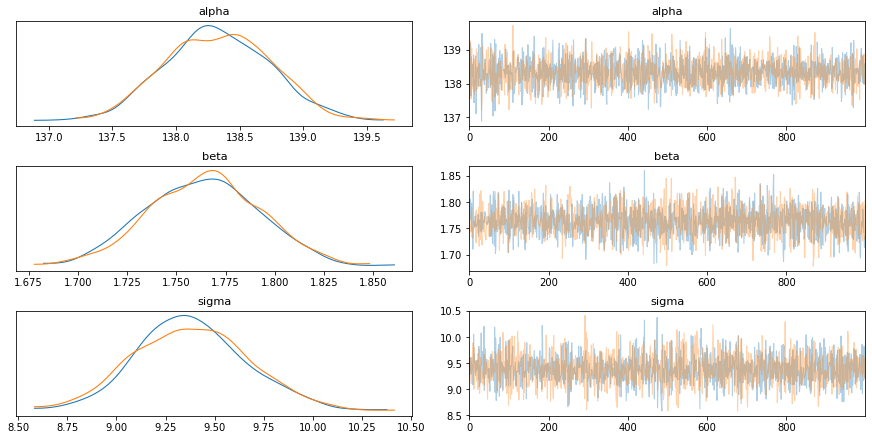

In [9]:
new_model.plot_trace_information()

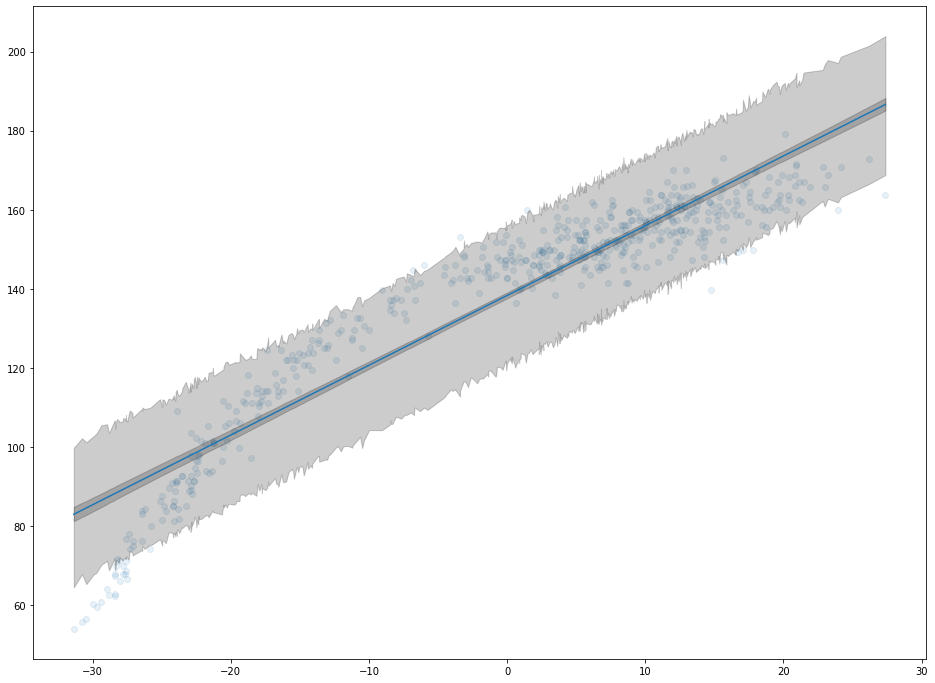

In [10]:
new_model.plot_full()

In [11]:
import pandas as pd

In [12]:
try:
    print(df.describe().T)
except NameError:
    raw_link = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/WaffleDivorce.csv"
    df = pd.read_csv(raw_link, sep=';')
    print(df.describe())

df['MedianAgeMarriage_s'] = (df['MedianAgeMarriage'] - df['MedianAgeMarriage'].mean()) / df['MedianAgeMarriage'].std()
df['Divorce_s'] = (df['Divorce'] - df['Divorce'].mean()) / df['Divorce'].std()
df['Marriage_s'] = (df['Marriage'] - df['Marriage'].mean()) / df['Marriage'].std()

       Population  MedianAgeMarriage   Marriage  Marriage SE    Divorce  \
count   50.000000           50.00000  50.000000    50.000000  50.000000   
mean     6.119600           26.05400  20.114000     1.399400   9.688000   
std      6.876156            1.24363   3.797905     0.796975   1.820814   
min      0.560000           23.20000  13.500000     0.390000   6.100000   
25%      1.635000           25.32500  17.125000     0.810000   8.300000   
50%      4.435000           25.90000  19.700000     1.185000   9.750000   
75%      6.677500           26.75000  22.100000     1.767500  10.900000   
max     37.250000           29.70000  30.700000     3.920000  13.500000   

       Divorce SE  WaffleHouses      South     Slaves1860  Population1860  \
count   50.000000     50.000000  50.000000      50.000000    5.000000e+01   
mean     0.961800     32.340000   0.280000   79378.340000    6.287293e+05   
std      0.525367     65.789587   0.453557  149730.921149    7.813127e+05   
min      0.24000

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az
import numpy as np
import seaborn as sns

In [14]:
def get_hdi_in_point(alpha, beta, x):
    result = alpha + beta * x
    [low_limit, high_limit] = az.hdi(np.array(result), hdi=.89)
    return low_limit, high_limit

In [15]:
with pm.Model() as m510:
    alpha = pm.Normal('alpha', mu=0, sd= 0.2)
    beta = pm.Normal('beta', mu=0, sd= 0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + beta * df['Marriage_s'])
    result = pm.Normal('result', mu=mu, sigma=sigma, observed=df['Divorce_s'])

with m510:
    trace_m510 = pm.sample(1000, tune=1000)
    df_trace_m510 = pm.trace_to_dataframe(trace_m510)

with pm.Model() as m511:
    alpha = pm.Normal('alpha', mu=0, sd= 0.2)
    beta = pm.Normal('beta', mu=0, sd= 0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + beta * df['MedianAgeMarriage_s'])
    result = pm.Normal('result', mu=mu, sigma=sigma, observed=df['Divorce_s'])

with m511:
    trace_m511 = pm.sample(1000, tune=1000)
    df_trace_m511 = pm.trace_to_dataframe(trace_m511)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


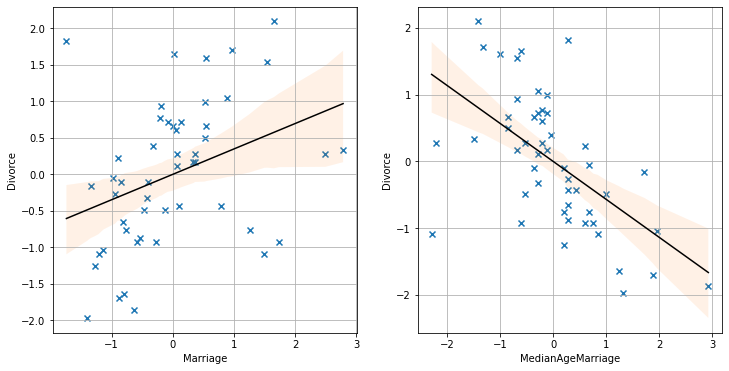

In [16]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12)
fig.set_figheight(6)

ax1.scatter(df['Marriage_s'], df['Divorce_s'], marker='x')
ax1.set_xlabel('Marriage')
ax1.set_ylabel('Divorce')

ax2.scatter(df['MedianAgeMarriage_s'], df['Divorce_s'], marker='x')
ax2.set_xlabel('MedianAgeMarriage')
ax2.set_ylabel('Divorce')

x_axis = np.sort(df['Marriage_s'])
y_axis = df_trace_m510['alpha'].mean() + df_trace_m510['beta'].mean() * np.sort(df['Marriage_s'])
ax1.plot(x_axis, y_axis, color='black')

low_line = []
up_line = []
for i in x_axis:
    [low_limit, high_limit] = get_hdi_in_point(df_trace_m510['alpha'], df_trace_m510['beta'], i)
    low_line.append(low_limit)
    up_line.append(high_limit)

ax1.fill_between(x_axis, low_line, up_line, alpha=.1)
ax1.grid(b=True)

x_axis = np.sort(df['MedianAgeMarriage_s'])
y_axis = df_trace_m511['alpha'].mean() + df_trace_m511['beta'].mean() * np.sort(df['MedianAgeMarriage_s'])
ax2.plot(x_axis, y_axis, color='black')

low_line = []
up_line = []
for i in x_axis:
    [low_limit, high_limit] = get_hdi_in_point(df_trace_m511['alpha'], df_trace_m511['beta'], i)
    low_line.append(low_limit)
    up_line.append(high_limit)

ax2.fill_between(x_axis, low_line, up_line, alpha=.1)
ax2.grid(b=True)

Perubahan nilai variabel menggunakan standarisasi ($\mu=0$ dan $\sigma=1$) menyebabkan beberapa perubahan interpretasi. Nilai intercept $\alpha$ akan mendekati 0 karena adanya standarisasi. Apabila nilai $\beta=1$ berarti perubahan satu standar deviasi pada variabel x-axis (`Marriage` dan `MedianAgeMarriage`) adalah perubhan satu standar deviasi pada variabel y-axis (`Divorce`)

Membandingkan parameter dari dua regeresi tidak menentukan apakah suatu variabel dapat mejadi prediktor yang baik.

**Pikiran sebelum membangun regresi**   
Disediakan tiga data $D$ sebagai jumlah perceraian, $M$ jumlah pernikahan, dan $A$ nilai tengah umur pernikahan. Untuk menjelaskan ketiga relasi antar variable, digunakan sesuatu yang dinamakan graph terutama graph asiklik dan terarah, Graph terarah ialah bentuk graph yang memiliki panah dari satu titik ke titik lain. Asiklik berarti setiap panah apabila ditelusuri tidak kembali ke titik itu berasal.

Graph akan membantu dalam menjelaskan suatu kausalitas suatu kejadian. Kausalitas yang dapat dibagun dari kasus diatas kurang lebih sebagai berikut $A \rightarrow M \rightarrow D \leftarrow A$ 

Ini akan membangun pertanyaan. Apabila $M$ terlihar berpengaruh terhadap $D$, apakah dikarenakan $A$ karena nilai $A$ berpengaruh langsung terhadap $D$?

Ini dapat dibedakan dengan membandingkan pengaruh $A \rightarrow D$ dan $M \rightarrow D$. Apabila pengaruh keduanya sama, maka mungkin? dapat disimpulkan bahwa nilai $M$ tidak berpengaruh terhadap $D$. Korelasi positif hanya dihasilkan  karena $A \rightarrow M$ saja.

**Menguji Implikasi**   
Conditional Independecies adalah salah satu yang dapat diuji dalam mengukur implikasi suatu variabel terhadap hasil. Ada dua bagian dalam conditional independece, pertama adalah menentukan pernyataan apakah data dapat dimasukan kedalam model atau tidak. Kedua, menentukan apakah pernyataan apakah suatu variable tidak terasosiasi dengan variabel lainya.

Secara formal dapat ditulis sebagai
$$ Y \bot\bot X|Z $$

Ketiga variabel $A$, $M$, dan $D$ ini akan menjadi tema dalam bab ini. 

### Regressi Multivariate

Regresi multivariate dapat dideskripsikan sebagai berikut

$$
\begin{align}
    D_i &\sim \text{Normal}(\mu_i, \sigma) &\text{[Probability of data target]} \\
    \mu_i &= \alpha + \beta_M M_i + \beta_A A_i &\text{[Linear Model]} \\
    \alpha &\sim \text{Normal}(0, 0.2) &\text{[Prior Intercept]} \\
    \beta_M &\sim \text{Normal}(0, 0.5) &\text{[Gradient untuk } M \text{]} \\
    \beta_A &\sim \text{Normal}(0, 0.5) &\text{[Gradient untuk } A \text{]} \\
    \sigma &\sim \text{Exponential}(1) &\text{[Prior untuk } \sigma \text{]} \\
    \end{align}
$$

betuk dari pemodelan multivariate ini hampir sama dengan pemodelan menggunakan model quadratic hanya saja suku terakhir dari sisi tangan kanan $\mu_i$ bukan lah nilai kuadrat tapi variabel lainya. Apakah implikasi menggunakan model linear yang terdiri dari lebih dari satu variabel prediktor?

Secara matematris, linear model dapat dibaca dengan
> Rearata perceraian pada satu negara bagian adalah hasil penjumlahan suatu nilai konstan $\alpha$, perkalian antara suatu nilai $\beta_M$ dan jumlah pernikahan pada negara bagian tersebut dan perkalian antara suatu nilai  $\beta_A$ dan nilai tengah umur pernikahan pada negara bagian tersebut.

Suatu nilai $\beta_M$ dan $\beta_A$ mengukur relasi antara variabel tersebut ($M$ dan $A$) dan target $D$.

In [17]:
with pm.Model() as m53:
    alpha = pm.Normal('alpha', mu=0, sd= 0.2)
    beta_M = pm.Normal('beta_M', mu=0, sd= 0.5)
    beta_A = pm.Normal('beta_A', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + 
                          beta_M * df['Marriage_s'] + 
                          beta_A * df['MedianAgeMarriage_s'])
    result = pm.Normal('result', mu=mu, sigma=sigma, observed=df['Divorce_s'])

with m53:
    trace_m53 = pm.sample(1000, tune=1000)
    df_trace_m53 = pm.trace_to_dataframe(trace_m53)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta_A, beta_M, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


In [18]:
var_array = ["alpha", "beta_M", "beta_A", "sigma"]
df_trace_m53[var_array].describe().round(2)

,alpha,beta_M,beta_A,sigma
count,2000.00,2000.00,2000.00,2000.00
mean,-0.00,-0.06,-0.60,0.83
std,0.10,0.15,0.15,0.09
min,-0.31,-0.61,-1.13,0.61
25%,-0.07,-0.16,-0.70,0.76
50%,-0.00,-0.05,-0.60,0.82
75%,0.07,0.04,-0.50,0.88
max,0.35,0.49,0.04,1.21


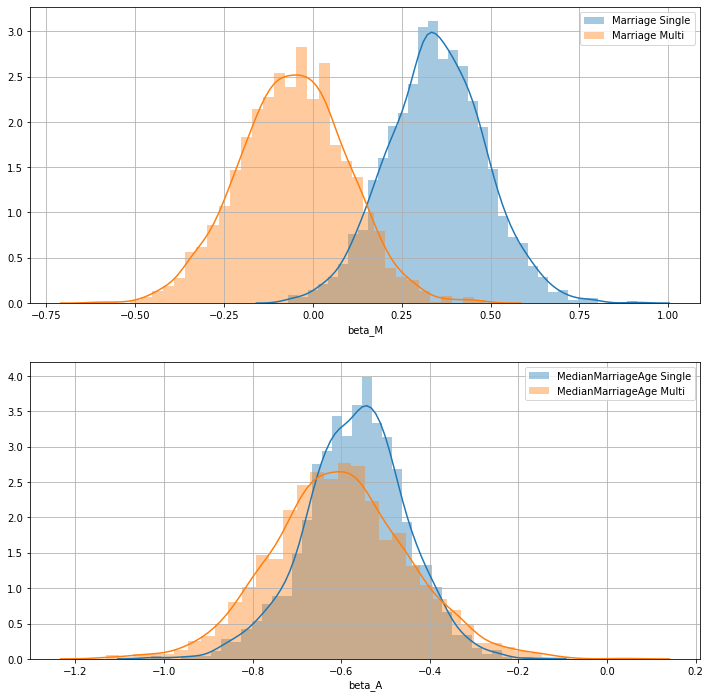

In [19]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(12)
fig.set_figheight(12)

sns.distplot(df_trace_m510['beta'], label='Marriage Single',ax=ax1)
sns.distplot(df_trace_m53['beta_M'], label='Marriage Multi',ax=ax1)
ax1.legend()
ax1.grid(b=True)

sns.distplot(df_trace_m511['beta'], label='MedianMarriageAge Single', ax=ax2)
sns.distplot(df_trace_m53['beta_A'], label='MedianMarriageAge Multi', ax=ax2)
ax2.legend()
ax2.grid(b=True)

Plot diatas membandingkan antara regresi yang dilakukan saat single variable dan multivariate. Plot pertama membandingkan variabel jumlah pernikahan dan plot kedua membandingkan nilai tengah umur pernikahan. Ada perbedaan nilai rerata antara dua model pada plot pertama. Plot multivariate memiliki nilai rerata mendekati nol apabila dibandingkan dengan single variate. Ini menandakan bahwa pada model multivariate, nilai jumlah pernikahan $M$ tidak berpengaruh banyak. 

Nilai tengah umur pernikahan $A$ memiliki rerata yang hampir sama. Perbedaan ada pada nilai standar deviasi. Standar deviasi pada single variate lebih kecil dibandingkan dengan multivariate. Ini menandakan bahwa regresi multivariate memiliki ketidakpastian lebih besar daripada regresi single variabel

## Plotting Multivariate Regression

Pak Richard mengajukan tiga jenis plot untuk memahami model multi variael. Ketiga plot tersebut adalah
1. *Predictor Residual Plot*. Memplot hasil dengan resildual dari variabel prediksi.
2. *Posterior Prediction Plot*. Membandingkan antara prediksi yang dihasilkan oleh model dan data yang tersedia
3. *Counterfactual Plots*. Menampilkan plot prediksi tentang sesuatu yang sebenarnya tidak terjadi berdasarkan model yang sudah dibangun

#### Predictor Residual Plot
Kasus bab ini memiliki dua variabel prediksi yaitu jumlah pernikahan $M$ dan nilai tengah umur pernikahan $A$. Salah satu variabel tersebut akan menjadi prediktor dan yang lainya akan menjadi terprediksi (feature dan label). Model ini akan menghasilkan sebuah regresi linear. Kedua variabel ini akan dibuat plotnya bersama regresi linear-nya. Kedua variabel ini dinormalisasi terlebih dahulu (menjadikan rerata pada masing-masing variabel adalah $0$).

Masing-masing variabel akan dibandingkan dengan jumlah perceraian $D$ yang menjadi variabel yang akan dicari. Dibuat model regresi dengan masing-masing variabel terhadap jumlah perceraian. Model yang akan dihasilkan akan sejumlah variabel yang terlibat. Pada kasus diatas, akan dibuat dua model.

In [20]:
with pm.Model() as m540:
    alpha = pm.Normal('alpha', mu = 0, sd = 0.2)
    beta = pm.Normal('beta', mu = 0, sd = 0.5)
    sigma = pm.Exponential('sigma', lam = 1)
    mu = pm.Deterministic('mu', alpha + beta * df['Marriage_s'])
    result = pm.Normal('result', mu = mu, sigma = sigma, observed=df['MedianAgeMarriage_s'])

with m540:
    trace_m540 = pm.sample(1000, tune=1000)
    df_trace_m540 = pm.trace_to_dataframe(trace_m540)
    
with pm.Model() as m541:
    alpha = pm.Normal('alpha', mu = 0, sd = 0.2)
    beta = pm.Normal('beta', mu = 0, sd = 0.5)
    sigma = pm.Exponential('sigma', lam = 1)
    mu = pm.Deterministic('mu', alpha + beta * df['MedianAgeMarriage_s'])
    result = pm.Normal('result', mu = mu, sigma = sigma, observed=df['Marriage_s'])

with m541:
    trace_m541 = pm.sample(1000, tune=1000)
    df_trace_m541 = pm.trace_to_dataframe(trace_m541)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [21]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s,Divorce_s,Marriage_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205,0.022644
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364,1.549802
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716,0.048974
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569,1.655123
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058,-0.266989


In [22]:
# How to shut pymc3 logging
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

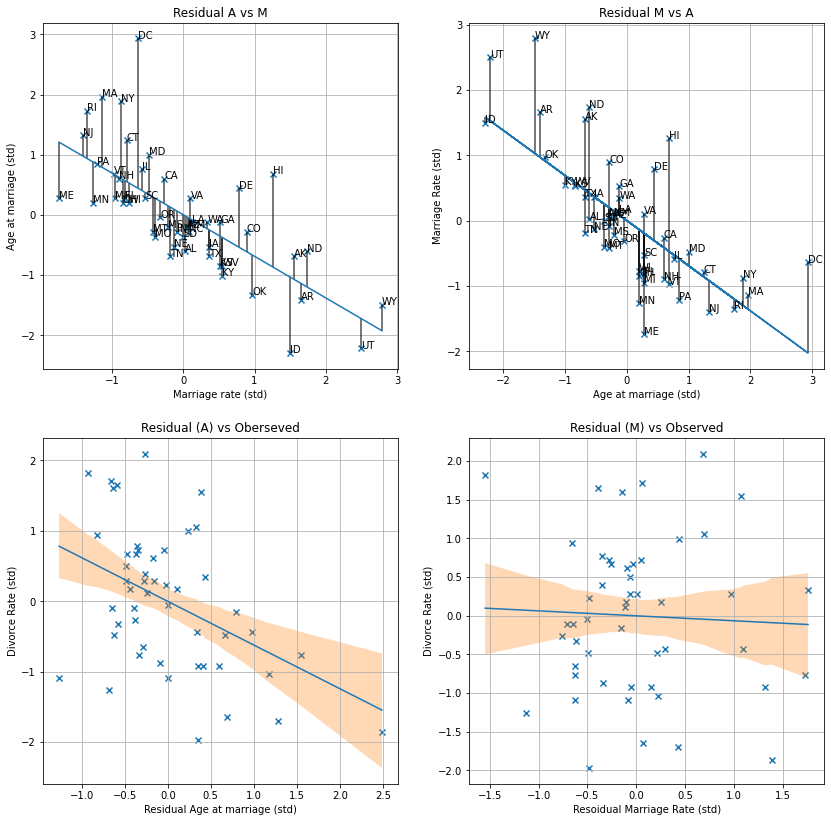

In [23]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(14)
fig.set_figheight(14)

ax1.scatter(df['Marriage_s'], df['MedianAgeMarriage_s'], marker='x')
x_axis = df.sort_values('Marriage_s')
p_residual = []
y_axis = []
for num, i in x_axis.iterrows():
    y_axis_result = df_trace_m540['alpha'].mean() + df_trace_m540['beta'].mean() * i['Marriage_s']
    y_axis.append(y_axis_result)
    ax1.vlines(i['Marriage_s'], y_axis_result, i['MedianAgeMarriage_s'], alpha=.7)
    ax1.annotate(i['Loc'], [i['Marriage_s'], i['MedianAgeMarriage_s']])
    p_residual.append(i['MedianAgeMarriage_s'] - y_axis_result)
ax1.set_ylabel('Age at marriage (std)')
ax1.set_xlabel('Marriage rate (std)')
ax1.set_title("Residual A vs M")
ax1.grid(b=True)
ax1.plot(x_axis['Marriage_s'], y_axis)

with pm.Model() as m542:
    alpha = pm.Normal('alpha', mu = 0, sd = 0.2)
    beta = pm.Normal('beta', mu = 0, sd = 0.5)
    sigma = pm.Exponential('sigma', lam = 1)
    mu = pm.Deterministic('mu', alpha + beta * p_residual)
    result = pm.Normal('result', mu = mu, sigma = sigma, observed=x_axis['Divorce_s'])
with m542:
    trace_m542 = pm.sample(1000, tune=1000, progressbar=False)
    df_trace_m542 = pm.trace_to_dataframe(trace_m542)

y_axis = []
low_line = []
up_line = []

for i in np.sort(p_residual):
    y_axis_result = df_trace_m542['alpha'].mean() + df_trace_m542['beta'].mean() * i
    [low_limit, high_limit] = get_hdi_in_point(df_trace_m542['alpha'], df_trace_m542['beta'], i)
    low_line.append(low_limit)
    up_line.append(high_limit)
    y_axis.append(y_axis_result)

ax3.scatter(p_residual, x_axis['Divorce_s'], marker='x')
ax3.set_xlabel('Residual Age at marriage (std)')
ax3.set_ylabel('Divorce Rate (std)')
ax3.plot(np.sort(p_residual), y_axis)
ax3.fill_between(np.sort(p_residual), low_line, up_line, alpha=.3)
ax3.set_title("Residual (A) vs Oberseved")
ax3.grid(b=True)

ax2.scatter(df['MedianAgeMarriage_s'], df['Marriage_s'], marker='x')
x_axis = df.sort_values('Marriage_s')
p_residual = []
y_axis = []
for num, i in x_axis.iterrows():
    y_axis_result = df_trace_m541['alpha'].mean() + df_trace_m541['beta'].mean() * i['MedianAgeMarriage_s']
    y_axis.append(y_axis_result)
    ax2.annotate(i['Loc'], [i['MedianAgeMarriage_s'], i['Marriage_s']])
    ax2.vlines(i['MedianAgeMarriage_s'], y_axis_result, i['Marriage_s'], alpha=.7)
    p_residual.append(i['Marriage_s'] - y_axis_result)
ax2.set_ylabel('Marriage Rate (std)')
ax2.set_xlabel('Age at marriage (std)')
ax2.plot(x_axis['MedianAgeMarriage_s'], y_axis)
ax2.set_title("Residual M vs A")
ax2.grid(b=True)

with pm.Model() as m543:
    alpha = pm.Normal('alpha', mu = 0, sd = 0.2)
    beta = pm.Normal('beta', mu = 0, sd = 0.5)
    sigma = pm.Exponential('sigma', lam = 1)
    mu = pm.Deterministic('mu', alpha + beta * p_residual)
    result = pm.Normal('result', mu = mu, sigma = sigma, observed=x_axis['Divorce_s'])
with m543:
    trace_m543 = pm.sample(1000, tune=1000, progressbar=False)
    df_trace_m543 = pm.trace_to_dataframe(trace_m543)

y_axis = []
low_line = []
up_line = []

for i in np.sort(p_residual):
    y_axis_result = df_trace_m543['alpha'].mean() + df_trace_m543['beta'].mean() * i
    [low_limit, high_limit] = get_hdi_in_point(df_trace_m543['alpha'], df_trace_m543['beta'], i)
    low_line.append(low_limit)
    up_line.append(high_limit)
    y_axis.append(y_axis_result)

ax4.scatter(p_residual, x_axis['Divorce_s'], marker='x')
ax4.set_xlabel('Resoidual Marriage Rate (std)')
ax4.set_ylabel('Divorce Rate (std)')
ax4.set_title("Residual (M) vs Observed")
ax4.plot(np.sort(p_residual), y_axis)
ax4.fill_between(np.sort(p_residual), low_line, up_line, alpha=.3)
ax4.grid(b=True)

In [24]:
print("Low LHS Plot Gradient Average (A) Based On Residual {:.2f}".format(df_trace_m542['beta'].describe()['mean']))
print("Low RHS Plot Gradient Average (M) Based On Residual {:.2f}".format(df_trace_m543['beta'].describe()['mean']))
print("Multivariate model gradient (A) {:.2f}".format(df_trace_m53['beta_A'].describe()['mean']))
print("Multivariate model gradient (M) {:.2f}".format(df_trace_m53['beta_M'].describe()['mean']))

Low LHS Plot Gradient Average (A) Based On Residual -0.62
Low RHS Plot Gradient Average (M) Based On Residual -0.06
Multivariate model gradient (A) -0.60
Multivariate model gradient (M) -0.06


> Bagaimana cara mealukan residual plot apabila feature lebih dari satu?

Pada plot sisi tangan kiri atas, didapati plot antara nilai tengah umur pernikahan dan jumlah pernikahan. Plot ini dibuat dengan cara membuat memperlakukan keduanya sebagai model. Garis regresi adalah hasil dari pemodelan. Apabila suatu negara bagian memiliki posisi diatas garis regresi, maka negara bagian tersebut dapat dikatakan nilai umur tengah pernikahan lebih dari yang diharapkan pada jumlah pernikahan pada garis tersebut. Begitu juga sebaliknya untuk negara bagian yang ada pada bagian bawah garis regressi.

Nilai residual dapat dihasilkan dari selisih antara nilai $y$ sebenernya --dalam kasus ini adalah nilai tengah umur pernikahan--dan $\hat{y}$--dalam kasus ini adalah nilai tengah umur pernikahan yang dihasilkan dari regressi.

Nilai residual ini dibuatkan model dengan variabel terobservasi (*actual outcome of interest*) --jumlah perceraian. Hasil regresi dan HDI dapat dilihat pada plot sisi tangan kiri bawah. Pada residual plot ini dapat dilihat adanya kecendurungan naiknya nilai residual berbanding terbalik dengan jumlah perceraian. Perlakuan ini juga diterapkan pada jumlah pernikahan yang mengisi sisi tangan kanan dari plot.

Tujuan dari residual plot ini adalah menghilangkan pengaruh dari variabel lain. Model regresi mengukur asosiasi antara variabel prediktor dengan variabel terobservasi setelah mengetahui residual antara variabel. Ini dapat dilihat pada gradient yang dihasilkan antara residual plot dan model mutivariate cukup mendekati. Sayangnya model mutivariate berasumsi bahwa variabel terobservasi dihasilkan dari model penambahan yang disesuaikan sedemikian rupa sedangkan hubungan antara variabel prediktor tidak selalu sama antara satu dengan yang lain.

#### Posterior Prediction Plot
Pemilihan distribusi pada variabel prior bersifat subjektif. Maka diperlukan validasi agar permilihan variabel ini lebih wajar dan tidak melenceng jauh sehingga model memberikan informasi yang berguna. Hasil sampling dari model yang dibangun juga ada baiknya dibandignkan dengan data yang tersedia (cross validation).

Pak Richard membandingkan antara nilai dari data yang teredia dan nilai dari sampling model. Dibarikan juga batasan 89% dari prediksi yang dihasilkan.

Plot tersebut memberikan informasi seberapa melenceng model yang dibangun tanpa harus mengkuantifikasi secara matematik.

In [25]:
def get_hdi_point(alpha, beta1, beta2, i1, i2):
    result = alpha + beta1 * i1 + beta2 * i2
    [low_limit, high_limit] = az.hdi(np.array(result), hdi=.89)
    return low_limit, high_limit

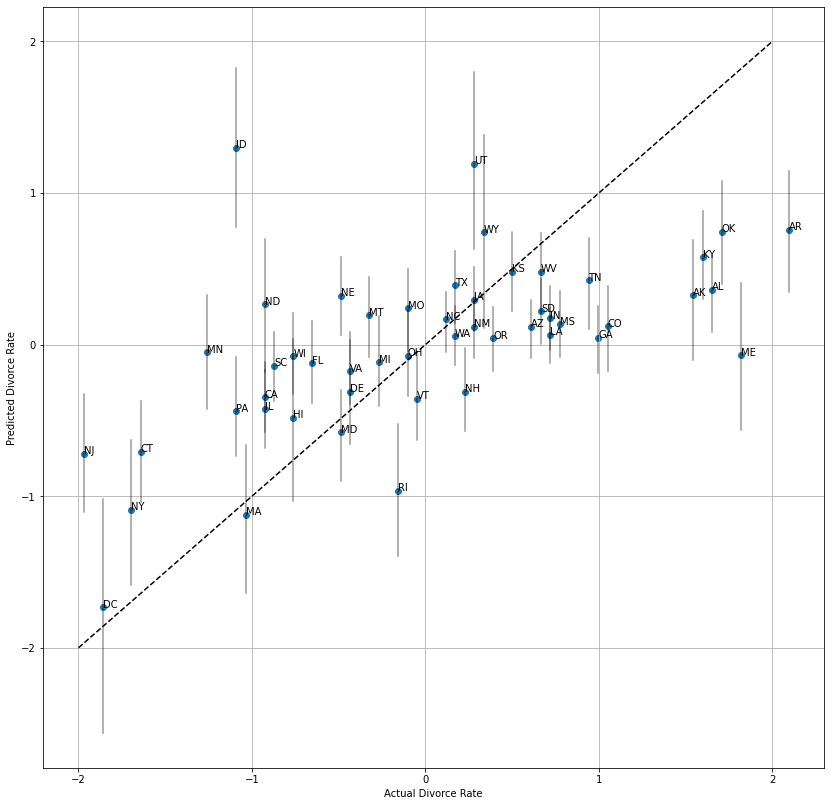

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(14)
fig.set_figheight(14)

ax.set_xlabel("Actual Divorce Rate")
ax.set_ylabel("Predicted Divorce Rate")

x_axis = []
y_axis = []

for index, row in df.iterrows():
    pred_divorce = df_trace_m53['alpha'].mean() + \
        df_trace_m53['beta_A'].mean() * row['MedianAgeMarriage_s'] + \
        df_trace_m53['beta_M'].mean() * row['Marriage_s']
    [low_limit, high_limit] = get_hdi_point(
        df_trace_m53['alpha'],
        df_trace_m53['beta_A'],
        df_trace_m53['beta_M'],
        row['MedianAgeMarriage_s'],
        row['Marriage_s'])
    ax.plot([row['Divorce_s']] * 2, [low_limit, high_limit], color='k', alpha=.4)
    ax.annotate(row['Loc'], [row['Divorce_s'], pred_divorce])
    x_axis.append(row['Divorce_s'])
    y_axis.append(pred_divorce)
ax.scatter(x_axis, y_axis)
ax.grid(b=True)
ax.plot([-2, 2], [-2,2], linestyle='dashed', color='k')

Pada plot diatas, diberikan sebuah garis yang menandakan bahwa prediksi dan data yan sebenarnya adalah sama. Semakin banyaknya suatu titik dekat ke garis, maka model semakin baik dalam memprediksi. Titik merepresentasikan negara bagian. Apabila suatu titik memiliki posisi diatas garis maka negara bagian tersebut memiliki jumlah perceraian yang lebih sedikit dibandingkan dengan perceraian hasil prediksi model. Beigtu juga sebaliknya, apabila negara bagian ada dibawah garis maka jumlah perceraian sebenernya melebihi apa yang diprediksi.

#### Counterfactual Plots

Hal yang paling mudah didapatkan dari counterfactual adalah melihat bagaimana prediksi berubah saat variabel prediktor berubah. Pada dasarnya ini adalah extrapolasi dari data yang tersedia. Model mejalankan prediksi dengan masukan diluar data yang tersedia. Tentunnya langkah ini rentan untuk menyesatkan dan tidak masuk akal.

Langkah yang disarankan oleh Pak Richard untuk melakukan counterfactual plot adalah sebagai berikut
1. Pilih satu variable yang akan menjadi variabel intervensi
2. Tentukan himpunan dari variabel intervensi tersebut
3. Untuk masing-masing nilai variabel intervensi, dan sampel dari posterior, gunakan model kausal untuk memprediksi variable lainnya.

In [27]:
with pm.Model() as m55:
    alpha = pm.Normal('alpha', mu=0, sd= 0.2)
    beta_M = pm.Normal('beta_M', mu=0, sd= 0.5)
    beta_A = pm.Normal('beta_A', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + 
                          beta_M * df['Marriage_s'] + 
                          beta_A * df['MedianAgeMarriage_s'])
    result = pm.Normal('result', mu=mu, sigma=sigma, observed=df['Divorce_s'])
    
    sigma_M = pm.Exponential('sigma_M', lam=1)
    beta_AM = pm.Normal('beta_AM', mu=0, sd=.5)
    alpha_M = pm.Normal('alpha_M', mu=0, sd=.2)
    mu_m = pm.Deterministic('mu_M', alpha_M +
                            beta_AM * df['MedianAgeMarriage_s'])
    result_M = pm.Normal('result_M', mu=mu_m, sd=sigma, observed=df["Marriage_s"])
    
with m55:
    trace_m55 = pm.sample(1000, tune=1000)
    ppc_m55 = pm.sample_posterior_predictive(trace_m55, var_names=['alpha_M', 'beta_AM', 'sigma_M'])
    df_trace_m55 = pm.trace_to_dataframe(trace_m55)

In [33]:
len(ppc_m55['alpha_M'])
len(ppc_m55['beta_AM'])

2000

In [36]:
from scipy.stats import norm
norm_form = norm.rvs(size=2000, loc=ppc_m55['alpha_M'] + ppc_m55['beta_AM'] * 0.1, scale=ppc_m55['sigma_M'])

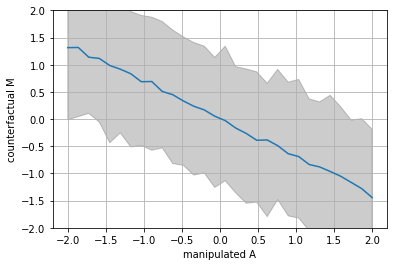

In [63]:
az.hdi(np.array(norm_form), hdi=.89)

x_axis = np.linspace(-2,2,30)
y_axis = []
low_lim = []
high_lim = []
for i in x_axis:
    norm_form = norm.rvs(size=2000, loc=ppc_m55['alpha_M'] + ppc_m55['beta_AM'] * i, scale=ppc_m55['sigma_M'])
    [low_limit, high_limit] = az.hdi(norm_form,hdi_prob=.8)
    y_axis.append(np.mean(norm_form))
    low_lim.append(low_limit)
    high_lim.append(high_limit)
    
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x_axis, y_axis)
ax.fill_between(x_axis, low_lim, high_lim, color='k', alpha=.2)
ax.set_ylim([-2,2])
ax.set_xlabel("manipulated A")
ax.set_ylabel("counterfactual M")
ax.grid(b=True)

## Masked Variable

In [69]:
raw_url = "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/milk.csv"
df = pd.read_csv(raw_url, sep=';')
print(df.shape)
df.head()

(29, 8)


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [91]:
def standarize(df, cols):
    df[cols + "_s"] = (df[cols] - df[cols].mean()) / df[cols].std()

def log_transform(df, cols):
    df[cols + "_l"] = np.log(df[cols])
    
standarize(df, 'kcal.per.g')
standarize(df, 'neocortex.perc')
log_transform(df, 'mass')

df[["kcal.per.g_s", "neocortex.perc_s", "mass_l"]]

,kcal.per.g_s,neocortex.perc_s,mass_l
0,-0.940041,-2.080196,0.667829
1,-0.816126,NaN,0.737164
2,-1.125913,NaN,0.920283
3,-1.001998,NaN,0.482426
4,-0.258511,NaN,0.783902
5,-1.063955,-0.508641,1.658228
6,-0.506340,-0.508641,1.680828
7,1.538249,0.010742,0.920283
8,1.662163,NaN,-0.342490
9,1.724120,0.213470,-0.385662


In [74]:
new_df = df[df['neocortex.perc_s'].notnull()]
new_df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,kcal.per.g_s,neocortex.perc_s,mass_l
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,0.667829
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,1.658228
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,1.680828
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,0.920283
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.385662


In [126]:
with pm.Model() as m56:
    alpha = pm.Normal('alpha', mu = 0, sd=1)
    beta = pm.Normal('beta', mu= 0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + beta * new_df['neocortex.perc_s'])
    result = pm.Normal('result', mu = mu, sd=sigma, observed=new_df['kcal.per.g_s'])
    
with m56:
    trace_m56 = pm.sample(1000, tune=1000)
    prior_pred_m56 = pm.sample_prior_predictive(samples=50)
    
with pm.Model() as m561:
    alpha = pm.Normal('alpha', mu = 0, sd=.2)
    beta = pm.Normal('beta', mu= 0, sd=.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + beta * new_df['neocortex.perc_s'])
    result = pm.Normal('result', mu = mu, sd=sigma, observed=new_df['kcal.per.g_s'])
    
with m561:
    trace_m561 = pm.sample(1000, tune=1000)
    prior_pred_m561 = pm.sample_prior_predictive(samples=50)
    df_trace_m561 = pm.trace_to_dataframe(trace_m561)
    
with pm.Model() as m562:
    alpha = pm.Normal('alpha', mu = 0, sd=.2)
    beta = pm.Normal('beta', mu= 0, sd=.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + beta * new_df['mass_l'])
    result = pm.Normal('result', mu = mu, sd=sigma, observed=new_df['kcal.per.g_s'])
    
with m562:
    trace_m562 = pm.sample(1000, tune=1000)
    prior_pred_m562 = pm.sample_prior_predictive(samples=50)
    df_trace_m562 = pm.trace_to_dataframe(trace_m562)
    
with pm.Model() as m563:
    alpha = pm.Normal('alpha', mu=0, sd=.2)
    beta_N = pm.Normal('beta_N', mu=0, sd=.5)
    beta_M = pm.Normal('beta_M', mu=0, sd=.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', alpha + beta_N * new_df['neocortex.perc_s'] + beta_M * new_df['mass_l'])
    result = pm.Normal('result', mu = mu, sd = sigma, observed=new_df['kcal.per.g_s'])

with m563:
    trace_m563 = pm.sample(1000, tune=1000)
    df_trace_m563 = pm.trace_to_dataframe(trace_m563)

Text(0.5, 0, 'neocortex')

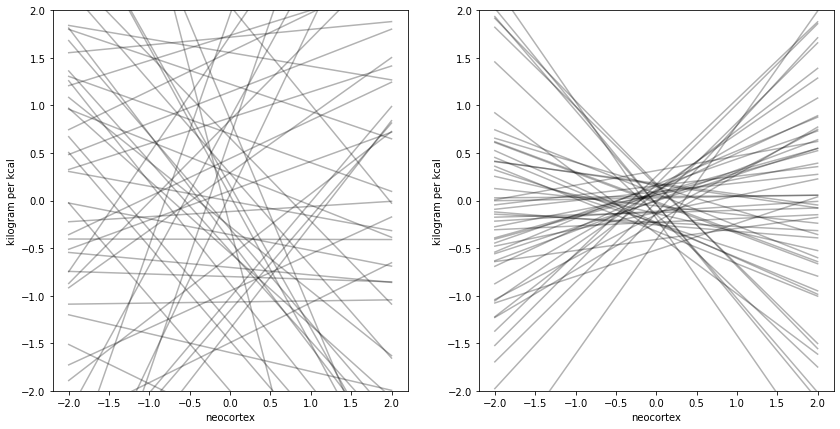

In [90]:
prior_pred.keys()
fig, [ax, ax1] = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(14)
fig.set_figheight(7)
for num, i in enumerate(prior_pred_m56['alpha']):
    x_axis = [-2, 2]
    y_axis = [
        prior_pred_m56['alpha'][num] + prior_pred_m56['beta'][num] * -2, 
        prior_pred_m56['alpha'][num] + prior_pred_m56['beta'][num] * 2
    ]
    ax.plot(x_axis, y_axis, color='k', alpha=.3)
    
ax.set_ylim([-2,2])
ax.set_ylabel('kilogram per kcal')
ax.set_xlabel('neocortex')

for num, i in enumerate(prior_pred_m561['alpha']):
    x_axis = [-2, 2]
    y_axis = [
        prior_pred_m561['alpha'][num] + prior_pred_m561['beta'][num] * -2, 
        prior_pred_m561['alpha'][num] + prior_pred_m561['beta'][num] * 2
    ]
    ax1.plot(x_axis, y_axis, color='k', alpha=.3)
    
ax1.set_ylim([-2,2])
ax1.set_ylabel('kilogram per kcal')
ax1.set_xlabel('neocortex')

In [103]:
def get_hdi_in_point(alpha, beta, x):
    result = alpha + beta * x
    [low_limit, high_limit] = az.hdi(np.array(result), hdi=.89)
    return low_limit, high_limit

Text(0, 0.5, 'kcal per gr (std)')

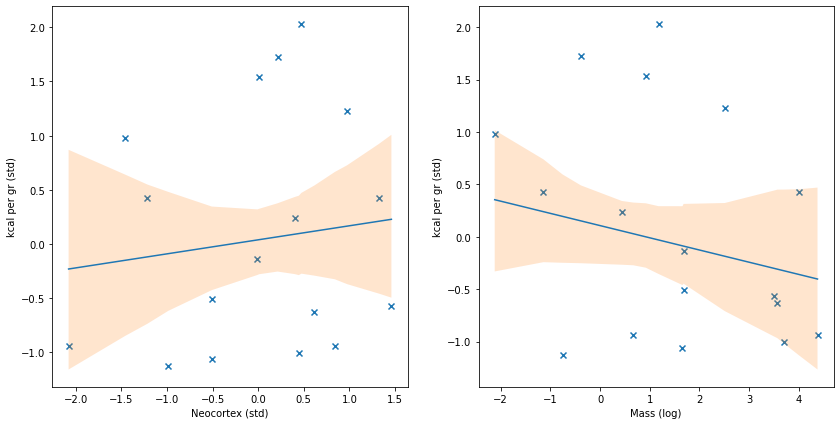

In [110]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(14)
fig.set_figheight(7)

ax1.scatter(new_df['neocortex.perc_s'], new_df['kcal.per.g_s'], marker='x')
ax2.scatter(new_df['mass_l'], new_df['kcal.per.g_s'], marker='x')

df_plot = new_df.sort_values('neocortex.perc_s')
y_axis = []
low_lim = []
high_lim = []
for i in df_plot['neocortex.perc_s']:
    y_axis.append(trace_m561['alpha'].mean() + trace_m561['beta'].mean() * i)
    [low_limit, high_limit] = get_hdi_in_point(trace_m561['alpha'], trace_m561['beta'], i)
    low_lim.append(low_limit)
    high_lim.append(high_limit)

ax1.fill_between(df_plot['neocortex.perc_s'], low_lim, high_lim, alpha=.2)
ax1.plot(df_plot['neocortex.perc_s'], y_axis)
ax1.set_xlabel("Neocortex (std)")
ax1.set_ylabel("kcal per gr (std)")

df_plot = new_df.sort_values('mass_l')
y_axis = []
low_lim = []
high_lim = []
for i in df_plot['mass_l']:
    y_axis.append(trace_m562['alpha'].mean() + trace_m562['beta'].mean() * i)
    [low_limit, high_limit] = get_hdi_in_point(trace_m562['alpha'], trace_m562['beta'], i)
    low_lim.append(low_limit)
    high_lim.append(high_limit)

ax2.fill_between(df_plot['mass_l'], low_lim, high_lim, alpha=.2)
ax2.plot(df_plot['mass_l'], y_axis)
ax2.set_xlabel("Mass (log)")
ax2.set_ylabel("kcal per gr (std)")

In [125]:
print("Neocortex")
print(df_trace_m561[['alpha', 'beta']].describe())

print("Mass")
print(df_trace_m562[['alpha', 'beta']].describe())

Neocortex
             alpha         beta
count  2000.000000  2000.000000
mean      0.038430     0.127707
std       0.160323     0.249925
min      -0.582136    -0.810495
25%      -0.068903    -0.024910
50%       0.036940     0.128149
75%       0.146374     0.284459
max       0.598105     0.983690
Mass
             alpha         beta
count  2000.000000  2000.000000
mean      0.108971    -0.117091
std       0.170245     0.119145
min      -0.465813    -0.547228
25%      -0.012954    -0.199723
50%       0.105328    -0.115955
75%       0.227831    -0.035968
max       0.663978     0.285823


In [139]:
print("Beta N mean {:.2f}".format(df_trace_m561["beta"].mean()))
print("Beta M mean {:.2f}".format(df_trace_m562["beta"].mean()))
print("\n")
print("Beta N mean {:.2f}".format(df_trace_m563["beta_N"].mean()))
print("Beta M mean {:.2f}".format(df_trace_m563["beta_M"].mean()))

Beta N mean 0.13
Beta M mean -0.11


Beta N mean 0.42
Beta M mean -0.24


Pada hasil prediski memperkirakan beta untuk masing-masing variable `Neocortex` dan `Mass` memiliki nilai gradient yang berbeda. Hasil nilai gradient pada model multivariate menghasilkan nilai gradient yang lebih besar jarak dari 0 dari model single variable. Jarak dari nol pada gradient menandakan pengaruh suatu prediktor terhadap variabel yang diobservasi. Semakin jauh jarak dari nol (nilai absolut) maka semakin berpengaruh variabel tersebut. Apabila negatif berarti berbanding terbalik dan apabila positif maka berbanding lurus.

Ini menghasilkan tiga buah dugaan kausalitas. Pertama adalah persen berat neocortex mempengaruhi massa dan energi dalam susu. Kedua adalah berat dari suatu primata mempengaruhi persenan neocortex dan energi dalam susu. Yang ketiga adalah adanya faktor extenal yang mempengaruhi nilai neocortex dan massa dalam primata. Tidak dapat diketahui dugaan yang benar dikareanakan adanya dugaan faktor external yang tidak diketahui nilainya. DAG dengan conditional independece yang sama dapat disebut sebagai **Markov Equivalence**


# Practice Question

5E1   
(1) $\mu_i = \alpha + \beta x_i$   
(2) $\mu_i = \beta_x x_i + \beta_z z_i$   
(3) $\mu_i = \alpha + \beta(x_i - z_i)$   
(4) $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$   

Persamaan pertama bukan bentuk dari multiple regresi linear karena hanya ada satu variabel yang berpengaruh terhadap gradient. Persamaan kedua ada dua buah yang bepengaruh terhadap gradient $\beta_x$ dan $\beta_z$ sehingga dapat dianggap menjadi regresi linear berganda. Persamaan ketiga bukan bentuk dari regresi linear berganda karena hanya memiliki satu gradient. Adanya dua variabel dapat dianggap menjadi satu $y_i = x_i - z_i$. Persamaan keempat adalah bentuk persamaan linear berganda karena memiliki dua buah gradient.